# Practicum: Does the Ticker-Picker Bandit Model Generate a Good Portfolio?
In this practicum, we will explore whether the ticker-picker bandit model (both risk-blind and risk-aware variants) can be used to generate a good portfolio of assets. 

> __Learning Objectives:__
> 
> By the end of this practicum, you should be able to:
> * __Build an investor preference model using bandit algorithm results:__ Incorporate ticker-picker preferences into the Cobb-Douglas utility model using the single index model framework and risk aversion parameters.
> * __Implement buy-and-hold and dynamic reallocation portfolio strategies:__ Construct portfolios based on investor preferences and compare performance across different reallocation frequencies.
> * __Evaluate portfolio performance against benchmark investments:__ Compare portfolio wealth trajectories to alternative investments including the S&P 500 ETF and risk-free bonds.

Let's get started!
___

## Setup, Data, and Prerequisites  a
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include-practicum.jl")); # include the Include.jl file

  Activating project at `c:\Users\abaek\OneDrive\Documents\GitHub\practicum-5660-f2025-abaeks`
   Installed ImageSegmentation ─ v1.10.0
   Installed ChunkCodecLibZstd ─ v1.0.0
   Installed QOI ─────────────── v1.0.2
   Installed NLPModels ───────── v0.21.5
   Installed JLD2 ────────────── v0.6.3
   Installed NNlib ───────────── v0.9.32
   Installed ImageMagick_jll ─── v7.1.2011+0
   Installed ChunkCodecLibZlib ─ v1.0.0
   Installed DataStructures ──── v0.19.3
   Installed MadNLP ──────────── v0.8.12
   Installed ChunkCodecCore ──── v1.0.0
   Installed Quaternions ─────── v0.7.7
   Installed Graphs ──────────── v1.13.2
   Installed IntervalSets ────── v0.7.13
   Installed HostCPUFeatures ─── v0.1.18
   Installed LDLFactorizations ─ v0.10.1
   Installed ImageMorphology ─── v0.4.7
    Updating `C:\Users\abaek\OneDrive\Documents\GitHub\practicum-5660-f2025-abaeks\Project.toml`
  [336ed68f] + CSV v0.10.15
  [c3611d14] + ColorVectorSpace v0.11.0
  [5ae59095] + Colors v0.13.1
  [a93c6f00] + D

For the practicum problem, all data and code is locally defined in the `data/` and `src/` folders. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) or the documentation for any external packages used.

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `11-18-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the dataset by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [16]:
original_dataset = MyTestingMarketDataSet()  |> x-> x["dataset"] # load the original dataset (training)

Dict{String, DataFrame} with 483 entries:
  "NI"   => 220×8 DataFrame…
  "EMR"  => 220×8 DataFrame…
  "CTAS" => 220×8 DataFrame…
  "HSIC" => 220×8 DataFrame…
  "KIM"  => 220×8 DataFrame…
  "PLD"  => 220×8 DataFrame…
  "IEX"  => 220×8 DataFrame…
  "BAC"  => 220×8 DataFrame…
  "CBOE" => 220×8 DataFrame…
  "EXR"  => 220×8 DataFrame…
  "NCLH" => 220×8 DataFrame…
  "CVS"  => 220×8 DataFrame…
  "DRI"  => 220×8 DataFrame…
  "DTE"  => 220×8 DataFrame…
  "ZION" => 220×8 DataFrame…
  "AVY"  => 220×8 DataFrame…
  "EW"   => 220×8 DataFrame…
  "EA"   => 220×8 DataFrame…
  "NWSA" => 220×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [17]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [18]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers_clean_price_data::Vector{String}` variable:

In [19]:
list_of_tickers_clean_price_data = keys(dataset) |> collect |> sort; # list of tickers in our clean dataset

Next, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable. In addition, we return a few other useful variables, such as the historical market growth rate, the mean and variance of the market growth, etc.

In [21]:
sim_model_parameters,Ḡₘ, Varₘ = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SPY-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    parameters = sim_model_parameters["data"]; # return

    Gₘ = sim_model_parameters["Gₘ"]; # Get the past market growth rate 
    Ḡₘ = sim_model_parameters["Ḡₘ"]; # mean of market growth rates
    Varₘ = sim_model_parameters["Varₘ"]; # variance of market growth

    # return -
    parameters, Ḡₘ, Varₘ;
end;

Now let's get a list of all tickers for which we have single index model parameters:

In [22]:
tickers_that_we_have_sim_data_for = keys(sim_model_parameters) |> collect |> sort;

We need to use only the tickers for which we have both price data and SIM parameters. We'll compute [the intersection of the two lists](https://docs.julialang.org/en/v1/base/collections/#Base.intersect) and store the result in the `list_of_tickers::Vector{String}` variable:

In [23]:
list_of_tickers = intersect(tickers_that_we_have_sim_data_for, list_of_tickers_clean_price_data);

### Constants and Parameters
Let's define some constants and parameters that we will use in this example. See the comment lines next to each variable for a description of its purpose, units, permissible values, etc.

In [31]:
Δt = (1.0 / 252.0); # time step (in years) between trading days (assumes 252 trading days per year)
risk_free_rate = 0.043; # annualized risk-free interest rate (4.3% per year)
ξ = 0.1; # weight of the ticker-picker preference in the investor context model
B = 1000.0; # total budget for investment (in USD)
investor_mood = :pessimistic; # TODO: update investor mood (:optimistic, :neutral, :pessimistic)
netid = "ab2679"; # TODO: replace with your netid

### Growth Rate Calculation
Let's compute the daily growth rate time series for all firms in our cleaned dataset using [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix). 

> __Note on indexing:__ The `log_growth_matrix()` function returns an array with `number_of_trading_days - 1` rows (it computes daily changes, which requires consecutive prices). Therefore, `all_firms_excess_return_matrix[t]` corresponds to the return from day `t` to day `t+1`. Be mindful of this offset when indexing into the return matrix.

We store the growth rate time series for each firm in the `all_firms_excess_return_matrix::Array{Float64,2}` variable.

In [25]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

Later, we'll need the (excess) growth rate time series for the market index. Let's compute that now and store it in the `Gₘ::Array{Float64,1}` variable (remember: we don't see this value beforehand in a real-world application):

In [26]:
Gₘ = let

    i = findfirst(x-> x == "SPY", list_of_tickers);
    Gₘ = all_firms_excess_return_matrix[:,i]; # return
end;

### Ticker-Picker Bandit Model
Finally, let's load the ticker-picker bandit models that we computed previously. We have three models reflecting the future opinion of the investor: risk-seeking (optimistic) $\lambda \geq -1$, risk-neutral (neutral) $\lambda = 0$, and risk-averse (pessimistic) $\lambda \leq 1$. 

> __Important:__ The bandit models provide *static* preference scores $p_i(\lambda)$ that were learned from historical data. In this practicum, we load these pre-computed preferences and incorporate them into our portfolio construction, but we do not dynamically learn or update $\lambda$ during the investment period. The risk aversion parameter $\lambda$ remains fixed at the value specified by the investor's mood (optimistic, neutral, or pessimistic).

We store the ticker-picker preference models in the `ticker_picker_preference_models::Dict{Symbol, DataFrame}` variable, where the keys are moods and the values are preference DataFrames for each ticker.

In [33]:
ticker_picker_preference_models = let

    # initialize -
    ticker_picker_preference_models = Dict{Symbol,DataFrame}();
    moods = [:optimistic, :neutral, :pessimistic];
    for mood ∈ moods
        rawdata = MyTickerPickerBanditModelResults(mood=mood); # many variables stored here
        ticker_picker_preference_models[mood] = rawdata["preferences"]; # get the preferences DataFrame;
    end
    ticker_picker_preference_models; # return
end;

### Alternative Investments
Throughout this practicum, we will assume the investor can invest in an alternative investment vehicle as a benchmark for comparison. We'll consider two alternative investments: `SPY`, the S&P 500 exchange-traded fund (ETF), and a zero-coupon risk-free STRIPS bond.

In [34]:
wealth_alternative_investment_SPY = let

    # initialize -
    wealth_array = Array{Float64, 1}(undef, maximum_number_trading_days); # preallocate wealth array
    initial_price_SPY = dataset["SPY"][1, :open]; # initial price of SPY
    number_of_shares_SPY = B / initial_price_SPY; # number of shares of SPY that can be purchased
    wealth_array[1] = number_of_shares_SPY * initial_price_SPY; # initial wealth is just the initial investment

    for day_index in 2:maximum_number_trading_days

        final_price_SPY = dataset["SPY"][day_index, :close]; # final price of SPY at the end of the investment period

        # compute wealth generated by holding SPY until the end of the investment period
        wealth_generated = number_of_shares_SPY * final_price_SPY; # wealth generated by holding SPY
        wealth_array[day_index] = wealth_generated; # store in array
    end
   
    wealth_array; # return
end;

Next, consider the risk-free STRIPS bond investment. In this case, the initial investment amount will grow at the risk-free rate until maturity. Let's compute the wealth time series for this investment and store it in the `wealth_alternative_investment_STRIPS::Array{Float64,1}` variable:

In [35]:
wealth_alternative_investment_STRIPS = let

    # initialize -
    wealth_array = Array{Float64, 1}(undef, maximum_number_trading_days); # preallocate wealth array
    wealth_array[1] = B; # initial wealth is just the initial investment

    for day_index in 2:maximum_number_trading_days

        # compute wealth generated by investing in risk-free STRIPS bond until the end of the investment period
        wealth_generated = B * exp(risk_free_rate * (day_index - 1) * Δt); # wealth generated by STRIPS bond
        wealth_array[day_index] = wealth_generated; # store in array
    end
   
    wealth_array; # return
end;

___

## Task 1: Buy and Hold Strategy
In this task, we'll use our ticker-picker results in combination with the Cobb-Douglas utility model and our investor preferences to formulate a portfolio of equity assets. We'll implement that portfolio on January 3, 2025 and hold it for the remainder of the year. 

The first question we'll explore is how to incorporate the ticker-picker preferences into our calculations. There are many ways to do this, but here, let's integrate the ticker-picker preferences into our investor preference model.

### Updated Investor Preference Model
The $\gamma_{i}$ coefficients in the Cobb-Douglas utility reflect the relative importance of each asset in generating utility for the investor. These coefficients can incorporate market conditions, sentiment, and other asset-specific information through an $m$-dimensional feature vector $\mathbf{x}_{i}\in\mathbb{R}^{m}$:
$$
\begin{align*}
\gamma_{i} & = \sigma\left(\mathbf{x}^{\top}_{i}\theta_{i}\right)\quad\forall{i}\in\mathcal{P}
\end{align*}
$$
where $\sigma:\mathbb{R}\rightarrow\mathbb{R}$ is an activation function such that $\sigma_{\theta}(x)\in[-1,1]$,
and $\mathbf{\theta}_{i}\in\mathbb{R}^{p}$ denotes the feature weights that can be learned from data or set based on subjective beliefs.

For a concrete implementation that includes ticker-picker preferences, suppose we use the single index model in combination with the ticker-picker data. This gives a feature vector $\mathbf{x}_{i} = \left(1,\mathbb{E}(\bar{g}_{m}),p_{i}(\lambda)\right)$, where $\mathbb{E}(\bar{g}_{m})$ is the expected growth rate of the market portfolio and $p_{i}(\lambda)$ is the ticker-picker preference for asset $i$ given risk aversion parameter $\lambda$.

The parameters $\theta_{i} = \left(\alpha_{i}/\beta^{\lambda},\beta^{1-\lambda}_{i},\xi\right)$ represent the risk-scaled firm-specific growth and relative risk with respect to the market portfolio, and $\xi$ is the weight of the investor's preference for the asset as given by the ticker-picker model (default weight of $\xi = 1$). Using the $\texttt{tanh}$ activation function, the coefficients are modeled as:
$$
\begin{align*}
    \gamma_{i} &= \texttt{tanh}\left(\alpha_{i}/{\beta_{i}^{\lambda}}+\beta^{1-\lambda}_{i}\cdot\mathbb{E}(\bar{g}_{m})+\xi \cdot p_{i}(\lambda)\right)\quad\forall{i}\in\mathcal{P}\Longrightarrow{-1<\gamma_{i}<1}
\end{align*}
$$
Assets with positive expected risk-adjusted growth rates yield $\gamma_{i} > 0$ (preferred), while those with negative rates yield $\gamma_{i}<0$ (non-preferred).

> __Important Note on Negative $\gamma$ Values:__ In standard Cobb-Douglas theory, all utility weights are positive. However, the $\texttt{tanh}$ activation function can produce negative values. In our portfolio construction algorithm, we handle this by forcing a minimum share purchase of $\epsilon$ shares for any asset with $\gamma_i < 0$. This allows the model to express "non-preferred but required" assets, though it does introduce a deviation from strict Cobb-Douglas assumptions. 

How do we set the $\xi$ parameter? This parameter controls the influence of the ticker-picker preferences relative to market fundamentals. If the ticker-picker model indicates a strong preference for an asset (i.e., $p_{i}(\lambda)$ is high), we might want to increase $\xi$ to give more weight to that preference. Conversely, if the ticker-picker model is uncertain or indicates a low preference, we might decrease $\xi$ to rely more on market fundamentals.

> __Heuristic $\xi$ Parameter:__ The $\xi$ parameter controls the influence of the ticker-picker preferences relative to market fundamentals. A higher $\xi$ places more weight on the investor's subjective preferences, while a lower $\xi$ emphasizes market-based factors. Adjusting $\xi$ allows investors to tailor their portfolios according to their confidence in the ticker-picker model versus traditional market indicators. For this practicum, we will use the following heuristic values for $\xi$ based on the results of the ticker-picker model:
$$
\begin{align*}
\xi & = 
\begin{cases}
\xi = 0.1 & \text{if}\;p_{i}(\lambda) > 0.5\text{default adjustable, and cutoff adjustable} \\
\xi = -100 & \text{if}\;0.0 < p_{i}(\lambda) \leq 0.5 \\
\end{cases}
\end{align*}
$$

For a deeper dive into the theoretical underpinnings of this model, please refer to the [Advanced Cobb-Douglas Analytical Solution notebook](Advanced-Cobb-Douglas-Analytical-Solution.ipynb).

### Investor Context Model
We build an investor context model using [the `MyInvestorMarketContextModel` type](src/Types.jl) that integrates ticker-picker preferences with market information. The model computes optimal portfolio weights using the updated Cobb-Douglas coefficients derived from firm-specific growth rates, market sensitivity, expected market returns, and investor preferences.

In [36]:
buy_and_hold_investor_context_model = let

    # initialize -
    mood = investor_mood; # this is the mood we specified above (:optimistic, :neutral, :pessimistic)
    list_of_my_investor_tickers = Array{String,1}();

    preference_df = ticker_picker_preference_models[mood];
    for row in eachrow(preference_df)
        push!(list_of_my_investor_tickers, row[:ticker]);
    end

    # initialize -
    model = build(MyInvestorMarketContextModel, (
        B = B, # budget
        tickers = list_of_my_investor_tickers,
        mood = mood,
        marketdata = dataset,
        preferences = ticker_picker_preference_models,
        Ḡₘ = Ḡₘ,
        risk_free_rate = risk_free_rate,
        singleindexmodel_parameters = sim_model_parameters,
        ξ = ξ,
        ϵ = 0.1, # minimum number of shares to buy/sell per trade
    ));

    model; # return
end;

Now, we can pass this context model to [our `shares(...)` function](src/Portfolio.jl) to compute the optimal number of shares to purchase for each asset in our portfolio.

In [37]:
result_case_1 = let

    # what day?
    t = 1; 
    fillpriceconvention = :open; # we were able to get filled at the open price

    # compute optimal shares to purchase -
    result = shares(t, buy_and_hold_investor_context_model, 
        fillpriceconvention = fillpriceconvention);

    result; # return
end

(shares = [0.109108663598541, 0.2605518798350332, 0.045255532444501895, 0.0, 0.13131644570528808, 0.0, 0.0, 0.0, 0.0, 0.07960090856824803  …  0.3454661795726663, 0.0, 0.4629414732071223, 0.17444937979003558, 0.0, 0.08936087948553204, 0.08582190161271289, 0.0, 1.2149876433464861, 0.0], price = [243.36, 113.94, 429.445, 121.65, 260.0, 171.4, 44.75, 70.88, 361.59, 914.33  …  150.96, 26.7, 166.25, 137.69, 381.48, 506.35, 123.96, 70.35, 90.15, 108.0], gamma = [0.19310727167008443, 0.21590396635569753, 0.14134141158138028, -1.0, 0.24830339756779488, -1.0, -1.0, -0.9999999999999983, -1.0, 0.5293113287692256  …  0.37927797119382234, -1.0, 0.5597291669149349, 0.17468757841093557, -1.0, 0.32907011544105197, 0.07736951877483265, -1.0, 0.7965770446294095, -1.0], tickers = ["AAPL", "ABT", "ADBE", "AMD", "AMGN", "BA", "BAC", "C", "CAT", "COST"  …  "PEP", "PFE", "PG", "TGT", "TSLA", "UNH", "UPS", "WFC", "WMT", "XOM"], cash = 1.1368683772161603e-13)

#### Wealth Calculation Case 1
Let's compute the wealth generated by holding this portfolio until the end of the investment period. For each trading day, we track the value of each asset position at the close price and maintain the same share quantities throughout the entire period.

We store the wealth in the `wealth_array_case_1::Array{Float64,2}` where each row is a day. The columns are given by:
* Columns $i=1\;\text{to}\;K$: These columns hold the value associated with our position in ticker $i$. If we don't hold ticker $i$, then this entry will be `0`. 
* Column $K+1$: This column holds the total value of all shares in the portfolio (valued at the close price for the day).
* Column $K+2$: This column holds the cash on hand (cash from share sales or unallocated capital).
* Column $K+3$: The total value of the portfolio (liquidation value plus cash on hand).

Construct the wealth array for this case:

In [38]:
wealth_array_case_1 = let

    # initialize -
    my_portfolio_tickers = result_case_1.tickers; # tickers in our portfolio
    number_of_tickers_in_portfolio = length(my_portfolio_tickers);
    wealth_array = Array{Float64,2}(undef, maximum_number_trading_days, number_of_tickers_in_portfolio+3); # final column is total wealth
    
    # let's initialize our wealth at day (given where we purchased the shares)
    for ticker ∈ eachindex(my_portfolio_tickers)
        n_shares = result_case_1.shares[ticker];
        price_at_purchase = result_case_1.price[ticker];
        wealth_array[1, ticker] = n_shares * price_at_purchase;
    end
    wealth_array[1, end-2] = sum(wealth_array[1, 1:end-3]); # total value of shares at day 1
    wealth_array[1, end-1] = result_case_1.cash; # cash leftover at day 1
    wealth_array[1, end] = sum(wealth_array[1, (end-2):(end-1)]); # total wealth at day 1

    # fill in the rest of the day, assuming we *held* this portfolio
    for day ∈ 2:maximum_number_trading_days
        for ticker ∈ eachindex(my_portfolio_tickers)
            n_shares = result_case_1.shares[ticker];
            price_at_day = dataset[my_portfolio_tickers[ticker]][day, :close]; # convention:we'll price at close
            wealth_array[day, ticker] = n_shares * price_at_day;
        end
        wealth_array[day, end-2] = sum(wealth_array[day, 1:end-3]); # total value of shares at this day
        wealth_array[day, end-1] = result_case_1.cash; # cash leftover at this day
        wealth_array[day, end] = sum(wealth_array[day, (end-2):(end-1)]); # total wealth at this day
    end    

    wealth_array; # return
end

220×43 Matrix{Float64}:
 26.5527  29.6873  19.4348  0.0  34.1423  …  1000.0    1.13687e-13  1000.0
 26.7316  29.4528  19.5133  0.0  33.9571      993.678  1.13687e-13   993.678
 26.4272  29.5466  19.1263  0.0  34.4128      989.756  1.13687e-13   989.756
 26.4807  29.7681  18.9883  0.0  34.6951      993.444  1.13687e-13   993.444
 25.8424  29.2626  18.3701  0.0  34.4351      989.931  1.13687e-13   989.931
 25.5751  29.4919  18.4869  0.0  35.4804  …   995.29   1.13687e-13   995.29
 25.4529  29.4476  18.6774  0.0  35.0746      986.78   1.13687e-13   986.78
 25.9537  28.9473  18.8842  0.0  35.3162      987.714  1.13687e-13   987.714
 24.9051  29.6795  19.3209  0.0  35.3806      988.249  1.13687e-13   988.249
 25.0928  29.5674  19.4594  0.0  35.7325      988.523  1.13687e-13   988.523
  ⋮                                       ⋱     ⋮                   
 29.4342  32.556   14.8144  0.0  41.4422     1033.35   1.13687e-13  1033.35
 29.2924  32.9233  14.7963  0.0  42.0475     1037.08   1.13687e-1

__Visualize:__ Compare the buy-and-hold portfolio wealth to benchmark investments.

> __What do we expect?__ The bandit portfolio should track between the SPY index and the risk-free bond, reflecting its intermediate risk profile. Early performance depends on initial portfolio composition and market conditions. The three strategies may diverge significantly if market movements favor or penalize the bandit's selected assets.

> __Color Legend:__
> * **Navy:** Bandit buy-and-hold portfolio constructed from ticker-picker preferences
> * **Red:** S&P 500 ETF (SPY) - passive market index
> * **Green:** Risk-free STRIPS bond

Which position is best?

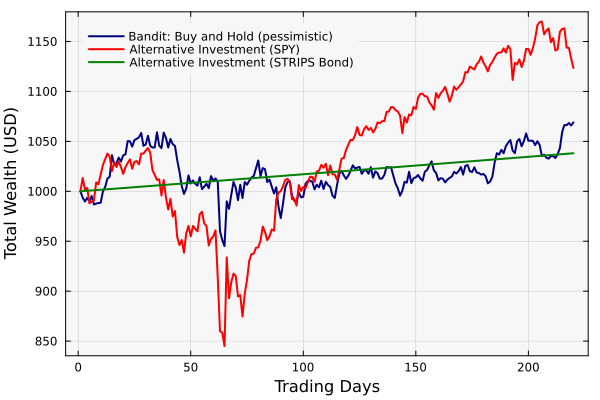

In [39]:
let

    # initialize -
    mood = buy_and_hold_investor_context_model.mood;

    plot(wealth_array_case_1[:, end],
        xlabel = "Trading Days",
        ylabel = "Total Wealth (USD)",
        label = "Bandit: Buy and Hold ($(mood))",
        lw = 2,
        linecolor = :navy,
    );

    plot!(wealth_alternative_investment_SPY,
        label = "Alternative Investment (SPY)",
        linecolor = :red,   
        lw = 2,
    );

    plot!(wealth_alternative_investment_STRIPS,
        label = "Alternative Investment (STRIPS Bond)",
        linecolor = :green,   
        lw = 2,
    );

    plot!(bg="gray97", background_color_outside="white", framestyle = :box, fg_legend = :transparent)

    # TODO: For submission, save this figure to disk by uncommenting the line below and rerunning this cell.
    # path_to_save_figure = joinpath(_PATH_TO_FIGS, "Practicum-5660-Case-1-Wealth-$(netid)-$(mood).pdf");
    # savefig(path_to_save_figure);
end

### How do our preferences evolve over time in the buy-and-hold case?
Visualize the preference weights $\gamma_{i}$ coefficients over the investment period as a grayscale image, where each row represents an asset and each column represents a trading day. 

> __What should we expect to see?__ In the buy-and-hold case, the weights remain constant because the portfolio is not rebalanced. Lighter colors indicate higher preference weights for that asset, while darker colors indicate lower (or zero) preferences. 

So what do we see?

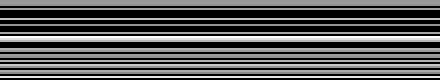

In [40]:
let

    # initialize -
    results_case = result_case_1;
    number_of_trading_days = maximum_number_trading_days;
    my_portfolio_tickers = buy_and_hold_investor_context_model.tickers; # tickers in our portfolio
    number_of_tickers_in_portfolio = length(my_portfolio_tickers);
    Γ = Array{Float64,2}(undef, number_of_tickers_in_portfolio, number_of_trading_days); # final rescaled preference weights over time

    # fill in the preference weights over time
    for day ∈ 1:number_of_trading_days
        result_of_day = results_case; # same result for all days in this case (we buy and hold)
        for ticker ∈ eachindex(my_portfolio_tickers)
            Γ[ticker, day] = result_of_day.gamma[ticker];
        end
    end

    # rescale this to 0,1 for visualization
    Γ = (Γ .- minimum(Γ)) ./ (maximum(Γ) - minimum(Γ));
    Gray.(Γ) # show grayscale image of the preference weights
end

___

## Task 2: Impact of Reallocation
In this task, we compare the buy-and-hold strategy from Task 1 to a dynamic reallocation strategy where the portfolio is reallocated based on updated market information. 

> __Strategy:__ Suppose we specify a binary vector $\mathbf{a}\in\{0,1\}^{K}$ where $a_{i} = 1$ indicates that we will reallocate the portfolio at trading day $i$, and $a_{i} = 0$ indicates that we will hold the current portfolio allocation. For example, if we set $a_{i} = 1$ for all trading days, we will reallocate the portfolio daily based on updated market information. If we set $a_{i} = 1$ only at the start of each month, we will reallocate monthly.

There are few ways to implement this strategy, we'll do the following:

> __Rebalancing Implementation:__ At each trading day $i$, if $a_{i} = 1$, we liquidate the current portfolio at the open. We assume that we get the open price for each asset on that day. We then recompute the optimal number of shares (where we now update the $\gamma_{i}$ coefficients based on the latest market information and ticker-picker preferences) and purchase those shares at a random price during that trading day (between the open and close). If $a_{i} = 0$, we hold the current portfolio allocation.

Let's set a value for the reallocation vector $\mathbf{a}$:

In [41]:
a = let

    # initialize -
    a = ones(maximum_number_trading_days); # Case: we reallocate daily
    # a = zeros(maximum_number_trading_days); # Case: we *never* reallocate

    # return -
    a;
end;

### What Information Should We Use to Update?
Given that our preference models are risk-aware single index models augmented with ticker-picker preferences, we could do several things here. However, let's update the preference coefficients $\gamma_{i}$ using a new value for the expected market growth rate, which we assume is an exponential moving average (EMA) of the market excess growth rate.

We store the SPY growth rate moving average in the `exponential_moving_average_market_growth::Array{Float64,1}` variable:

In [42]:
exponential_moving_average_market_growth, α = let

    # initialize -
    α = 0.2; # smoothing factor
    ema_array = Array{Float64,1}(undef, length(Gₘ));
    ema_array[1] = Gₘ[1]; # initial value

    for t in 2:length(Gₘ)
        ema_array[t] = α * Gₘ[t] + (1 - α) * ema_array[t-1];
    end

    ema_array, α; # return
end;

__Visualize:__ Let's plot the actual market excess growth rate alongside the exponential moving average. The smoothed EMA (orange) removes daily noise from market returns (blue), revealing the underlying trend in the market return.

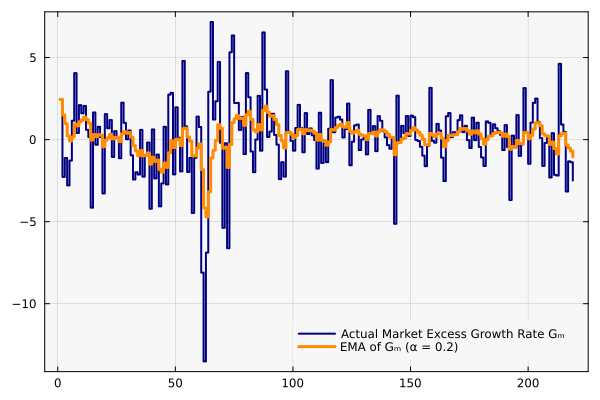

In [43]:
let
    plot(Gₘ, label="Actual Market Excess Growth Rate Gₘ", lw=2, linecolor=:navy, linetype=:steppost)
    plot!(exponential_moving_average_market_growth, label="EMA of Gₘ (α = $α)", lw=3, linecolor=:darkorange, linetype=:steppost)
    plot!(bg="gray97", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
end

### Reallocation Implementation
Let's implement a reallocation strategy.

> __Strategy:__ Reallocate the portfolio at each trading day (for reallocation days where $a_{t} = 1$). If $a_{t} = 0$, maintain the previous portfolio. Otherwise, reallocate. 
> 
> The reallocation process: 
> 1. Liquidate the previous portfolio at the market open price to compute total wealth and add this value to the cash on hand. 
> 2. Update the market context model with current wealth and the EMA-smoothed market growth rate from the previous day. 
> 3. Compute new optimal share quantities based on updated preferences using [the `shares(...)` function](src/Portfolio.jl). This function solves the Cobb-Douglas investor's optimization problem using the updated $\gamma_{i}$ coefficients.
>
> __Note on Transaction Costs:__ This implementation assumes zero transaction costs, zero bid-ask spreads, and no price slippage. In reality, frequent reallocation incurs trading costs that can significantly erode returns. Students should consider adding transaction cost modeling to evaluate whether the reallocation strategy remains attractive under more realistic conditions.
> 
> __Simplifying Assumption on Cash:__ Between reallocation periods, cash holdings are treated as non-earning (no interest accrual). In practice, uninvested cash would typically earn the risk-free rate. 
> 
> __Implementation Note:__ We use a deepcopy of the context model to avoid unintended side effects. The budget is updated in-place at each reallocation point, but the deepcopy ensures that the original context model remains unchanged for reference.

We store the reallocation results in the `result_dictionary_case_2::Dict{Int,NamedTuple}` dictionary, where the keys are the trading day index and the values are results `NamedTuple` for that day. See [the `shares(...)` function](src/Portfolio.jl) documentation for details on the structure of the results `NamedTuple`.

In [44]:
result_dictionary_case_2 = let

    # initialize -
    results_dictionary = Dict{Int, NamedTuple}(); # key: trading day index, value: results named tuple
    mycontextmodel = deepcopy(buy_and_hold_investor_context_model); # deepcopy to avoid mutating original model
    fillpriceconvention = :open; # we use the open price for deterministic, reproducible results
    tickers = mycontextmodel.tickers; # tickers in our portfolio
    marketdata = mycontextmodel.marketdata; # local dataset

    # day one, we use the case 1 portfolio
    results_dictionary[1] = result_case_1;

    # iterate through the remaining trading days
    for day_index ∈ 2:maximum_number_trading_days
        
        if (a[day_index] == 1.0) # in this case, we reallocate the portfolio at market open

            # Task 1: We need to sell our previous portfolio to compute our total wealth (that we will use to reallocate)
            # ok, so we liquidate our previous portfolio (at market open)
            cash = results_dictionary[day_index - 1].cash; # cash leftover from previous portfolio
            nₒ = results_dictionary[day_index - 1].shares; # number of shares of each asset in previous portfolio
            total_wealth_previous_day = 0.0;
            for i ∈ eachindex(nₒ)
                ticker = tickers[i];
                price_at_open = marketdata[ticker][day_index, :open]; # price at market open
                total_wealth_previous_day += nₒ[i] * price_at_open; # compute total wealth from previous portfolio
            end
            # println("Reallocating: Total wealth from previous portfolio at day $(day_index): \$$(round(total_wealth_previous_day, digits=2))");

            # update our market context model with the new information
            mycontextmodel.Ḡₘ = exponential_moving_average_market_growth[day_index - 1]; # average market growth rate observed at the end of previous day
            mycontextmodel.B = (total_wealth_previous_day + cash); # update budget to total wealth from previous portfolio + cash leftover

            # Task 2: Compute new optimal shares to purchase based on updated budget, and market information
            result_new = shares(day_index, mycontextmodel, fillpriceconvention = :random); # random: default. Use {:open, :volume_weighted_average_price, :close} price for deterministic, reproducible results

            # store in results dictionary
            results_dictionary[day_index] = result_new;
        else
            # in this case, we hold our previous portfolio
            results_dictionary[day_index] = results_dictionary[day_index - 1]; # just carry forward previous result
        end        
    end

    # return -
    results_dictionary
end;

#### Wealth Calculation for Case 2
Let's compute the wealth generated by the dynamic reallocation strategy. For each trading day, track positions and values based on the reallocation results. On days without reallocation, carry forward the previous portfolio; on reallocation days, use the new portfolio weights computed from updated market information and preferences.

We store the wealth in the `wealth_array_case_2::Array{Float64,2}` where each row is a day. The columns are given by:
* Columns $i=1\;\text{to}\;K$: These columns hold the value associated with our position in ticker $i$. If we don't hold ticker $i$, then this entry will be `0`. 
* Column $K+1$: This column holds the total value of all shares in the portfolio (valued at the close price for the day).
* Column $K+2$: This column holds the cash on hand (cash from share sales or unallocated capital).
* Column $K+3$: The total value of the portfolio (liquidation value plus cash on hand).

Construct the wealth array for this case:

In [45]:
wealth_array_case_2 = let

    # initialize -
    my_portfolio_tickers = result_case_1.tickers; # tickers in our portfolio
    number_of_tickers_in_portfolio = length(my_portfolio_tickers);
    wealth_array = Array{Float64,2}(undef, maximum_number_trading_days, number_of_tickers_in_portfolio+3); # final column is total wealth
    
    # let's initialize our wealth at day 1 (given where we purchased the shares)
    for ticker ∈ eachindex(my_portfolio_tickers)
        n_shares = result_case_1.shares[ticker];
        price_at_purchase = result_case_1.price[ticker];
        wealth_array[1, ticker] = n_shares * price_at_purchase;
    end
    wealth_array[1, end-2] = sum(wealth_array[1, 1:end-3]); # total value of shares at day 1
    wealth_array[1, end-1] = result_case_1.cash; # cash leftover at day 1
    wealth_array[1, end] = sum(wealth_array[1, (end-2):(end-1)]); # total wealth at day 1

    # fill in the remaining days
    for day ∈ 2:maximum_number_trading_days
        results_of_day = result_dictionary_case_2[day];
        for ticker ∈ eachindex(my_portfolio_tickers)
            n_shares = results_of_day.shares[ticker];
            price_at_day = dataset[my_portfolio_tickers[ticker]][day, :close]; # convention: price at close
            wealth_array[day, ticker] = n_shares * price_at_day;
        end
        wealth_array[day, end-2] = sum(wealth_array[day, 1:end-3]); # total value of shares at this day
        wealth_array[day, end-1] = results_of_day.cash; # cash leftover at this day
        wealth_array[day, end] = sum(wealth_array[day, (end-2):(end-1)]); # total wealth at this day
    end    

    wealth_array; # return
end;

__Visualize:__ Compare portfolio wealth trajectories across all strategies over the full investment period.

> __What do we expect?__ Daily reallocation __may__ provide more responsiveness to market changes than buy-and-hold, but the magnitude of improvement depends on market regime and reallocation effectiveness. If markets are trending (strongly up or down), buy-and-hold may outperform due to lower transaction sensitivity. In volatile or mean-reverting markets, reallocation can capture opportunities missed by static positioning.

> __Color Legend:__
> * **Navy:** Bandit buy-and-hold portfolio, fixed positions throughout period
> * **Orange:** Bandit daily reallocation, adjusts positions each reallocation day (controlled using the $\mathbf{a}$ vector)
> * **Red:** S&P 500 ETF (SPY) passive market index. This serves as a benchmark for overall market performance.
> * **Green:** Risk-free STRIPS bond. This is the risk-free benchmark.

Do we see an improvement with reallocation?

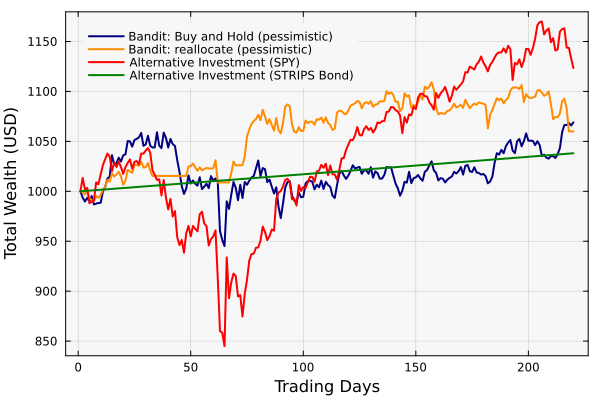

In [46]:
let

    # initialize -
    mood = buy_and_hold_investor_context_model.mood;

    plot(wealth_array_case_1[:, end],
        xlabel = "Trading Days",
        ylabel = "Total Wealth (USD)",
        label = "Bandit: Buy and Hold ($(mood))",
        lw = 2,
        linecolor = :navy,
    );

    plot!(wealth_array_case_2[:, end],
        xlabel = "Trading Days",
        ylabel = "Total Wealth (USD)",
        label = "Bandit: reallocate ($(mood))",
        lw = 2,
        linecolor = :darkorange,
    );

    plot!(wealth_alternative_investment_SPY,
        label = "Alternative Investment (SPY)",
        linecolor = :red,   
        lw = 2,
    );

    plot!(wealth_alternative_investment_STRIPS,
        label = "Alternative Investment (STRIPS Bond)",
        linecolor = :green,   
        lw = 2,
    );

    plot!(bg="gray97", background_color_outside="white", framestyle = :box, fg_legend = :transparent)

    # TODO: For submission, save this figure to disk by uncommenting the line below and rerunning this cell.
    # path_to_save_figure = joinpath(_PATH_TO_FIGS, "Practicum-5660-Case-2-Wealth-$(netid)-$(mood).pdf");
    # savefig(path_to_save_figure);
end

### How do our preferences evolve for the reallocation case?
We visualize the preference coefficients across trading days for the daily reallocation strategy. 

> __What do we expect to see?__ Unlike the buy-and-hold case, the preferences in the reallocation case should vary over time as the portfolio adjusts to new information. The portfolio preferences are sensitive to market changes, particularly during volatile periods. In these cases, we should see large shifts in preference allocations, sometimes moving toward cash-only positions.

Do the preferences change with market conditions?

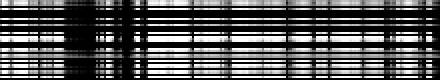

In [48]:
let

    # initialize -
    results_case = result_dictionary_case_2;
    number_of_trading_days = maximum_number_trading_days;
    my_portfolio_tickers = buy_and_hold_investor_context_model.tickers; # tickers in our portfolio
    number_of_tickers_in_portfolio = length(my_portfolio_tickers);
    Γ = Array{Float64,2}(undef, number_of_tickers_in_portfolio, number_of_trading_days); # final rescaled preference weights over time

    # fill in the preference weights over time
    for day ∈ 1:number_of_trading_days
        result_of_day = results_case[day];
        for ticker ∈ eachindex(my_portfolio_tickers)
            Γ[ticker, day] = result_of_day.gamma[ticker];
        end
    end

    # rescale this to 0,1 for visualization
    Γ = (Γ .- minimum(Γ)) ./ (maximum(Γ) - minimum(Γ));
    Gray.(Γ) # show grayscale image of the preference weights
end

___

## Discussion Questions
Use the figures that you generated, and the logic in this notebook to think about the following (open-ended) questions.

### Question 1
How might you modify the $\mathbf{a}$ reallocation action vector calculation to incorporate your own risk preferences or market views? How do the results differ across the optimistic, neutral, and pessimistic investor moods, and what does this suggest about the robustness of the bandit preferences?

1. You could modify the 𝑎 reallocation action vector by weighting the bandit’s preference scores with additional factors that reflect your own risk aversion (e.g., penalizing high-beta or high-risk assets) or market views (e.g., tilting toward sectors you expect to outperform). An optimistic investor mood tends to produce more aggressive reallocations toward higher-growth, higher-risk tickers, while a pessimistic mood shifts allocations toward safer assets with lower downside risk. The neutral case usually lies between these two, balancing expected growth and risk. Comparing the three, the relative ranking of top tickers often remains similar even as allocation magnitudes change. This suggests the bandit’s learned preferences are reasonably robust, with investor mood mainly affecting the intensity of allocations rather than completely changing the underlying preferences.

In [50]:
did_I_answer_question_1 = true; # set to true if you answered question 1

### Question 2
How does the frequency of portfolio reallocation impact overall performance, and what trade-offs are involved? How would you adapt this reallocation strategy for your own investment approach, considering transaction costs or tax implications?

__Answer 2:__ More frequent portfolio reallocation allows the strategy to react quickly to new information, which can improve performance in changing markets, but it also increases transaction costs and turnover. Less frequent reallocation reduces costs and tax liabilities but may cause the portfolio to adjust more slowly to shifts in asset performance. The trade-off is therefore between responsiveness and efficiency. For my own investment approach, I would use less frequent rebalancing or apply thresholds so trades only occur when allocation changes are meaningful. This balances capturing the bandit’s insights while limiting transaction costs and potential tax impacts.

In [51]:
did_I_answer_question_2 = true; # TODO: set to true after you answer question 2

### Question 3
How does the $\xi$ parameter control the balance between bandit preferences and market fundamentals in the portfolio allocation? What are the implications of the heuristic values used for $\xi$, and how might you modify this heuristic for your own investment strategy?

__Answer 3:__ The 𝜉 parameter controls how much weight is given to the bandit-derived preferences versus market fundamentals in the portfolio allocation, with higher 𝜉 placing more emphasis on the bandit’s learned signals and lower 𝜉 relying more on fundamental or benchmark weights. The heuristic values for 𝜉 provide a simple, interpretable way to interpolate between these two information sources, but they may not be optimal across all market regimes. If 𝜉 is set too high, the portfolio may overreact to noisy or short-term bandit signals, while too low a value can dilute potentially valuable learning. For my own strategy, I would adapt 𝜉 dynamically based on market volatility or confidence in the bandit’s recent performance. This would allow the allocation to lean more on fundamentals during uncertain periods and more on the bandit when its signals appear reliable.

In [52]:
did_I_answer_question_3 = true; # TODO: set to true after you answer question 3

## Summary
This practicum integrates bandit algorithm results with investor preferences to construct and compare portfolio strategies using dynamic market information.

> __Key Takeaways:__
> 
> * **Bandit preferences improve Cobb-Douglas utility coefficients:** Incorporating ticker-picker preferences into the investor utility model enriches portfolio construction beyond market factor information alone, capturing learned patterns from historical asset performance.
> * **Reallocation frequency impacts portfolio performance:** Dynamic reallocation allows portfolios to respond to evolving market conditions and preference changes, with potential benefits or costs depending on market regime and transaction considerations.
> * **Benchmark comparison validates strategy effectiveness:** Comparing bandit portfolios to passive indexing and risk-free alternatives provides evidence for whether learned preferences generate excess returns relative to simple strategies.

Portfolio construction that adapts to market changes can potentially outperform static strategies through active preference updating.
___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, etc.

In [53]:
@testset verbose = true "Practicum Notebook 5660 Fall 2025" begin
    @testset "Setup, Data, and Prerequisites" begin
        @test !isempty(dataset)
        @test Set(list_of_tickers_clean_price_data) == Set(keys(dataset))
        @test all(nrow(df) == maximum_number_trading_days for df in values(dataset))
        @test all(haskey(sim_model_parameters, t) for t in list_of_tickers)
        @test size(all_firms_excess_return_matrix) == (maximum_number_trading_days - 1, length(list_of_tickers))
        @test all(isfinite, all_firms_excess_return_matrix)
        @test netid != "jdv27" # make sure you updated your netid
    end

    @testset "Task 1: Buy and Hold Strategy" begin
        @test result_case_1.tickers == buy_and_hold_investor_context_model.tickers
        @test length(result_case_1.shares) == length(buy_and_hold_investor_context_model.tickers)
        @test length(result_case_1.price) == length(buy_and_hold_investor_context_model.tickers)
        @test all(>(0.0), result_case_1.price)
        spent_case_1 = sum(result_case_1.shares .* result_case_1.price)
        @test isapprox(spent_case_1 + result_case_1.cash, buy_and_hold_investor_context_model.B; rtol=1e-8, atol=1e-8)
        @test size(wealth_array_case_1) == (maximum_number_trading_days, length(buy_and_hold_investor_context_model.tickers) + 3)
        @test all(isapprox.(wealth_array_case_1[:, end], wealth_array_case_1[:, end-1] .+ wealth_array_case_1[:, end-2]; atol=1e-8, rtol=1e-8))
        @test isapprox(wealth_array_case_1[1, end], buy_and_hold_investor_context_model.B; rtol=1e-8, atol=1e-8)
    end

    @testset "Task 2: Impact of Reallocation" begin
        @test length(a) == maximum_number_trading_days
        @test length(result_dictionary_case_2) == maximum_number_trading_days
        @test result_dictionary_case_2[1] == result_case_1
        @test size(wealth_array_case_2) == (maximum_number_trading_days, length(buy_and_hold_investor_context_model.tickers) + 3)
        @test all(isfinite, wealth_array_case_2)
        @test all(isapprox.(wealth_array_case_2[:, end], wealth_array_case_2[:, end-1] .+ wealth_array_case_2[:, end-2]; atol=1e-8, rtol=1e-8))
        @test isapprox(wealth_array_case_2[1, end], buy_and_hold_investor_context_model.B; rtol=1e-8, atol=1e-8)

        @testset "Daily Allocation Integrity" begin
            for day in 1:maximum_number_trading_days
                res = result_dictionary_case_2[day]
                K = length(buy_and_hold_investor_context_model.tickers)
                @test length(res.shares) == K
                @test length(res.price) == K
                @test length(res.gamma) == K
                @test all(res.price .> 0)
                spent = sum(res.shares .* res.price)
                @test spent + res.cash >= 0
            end
        end
    end

    @testset "Questions Answered" begin
        @test did_I_answer_question_1 == true
        @test did_I_answer_question_2 == true
        @test did_I_answer_question_3 == true
    end
end;

Test Summary:                     | Pass  Total  Time
Practicum Notebook 5660 Fall 2025 | 1125   1125  0.1s
  Setup, Data, and Prerequisites  |    7      7  0.1s
  Task 1: Buy and Hold Strategy   |    8      8  0.0s
  Task 2: Impact of Reallocation  | 1107   1107  0.0s
  Questions Answered              |    3      3  0.0s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___